In [44]:
# Step 1: Upload the file
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Upload the dataset
uploaded = files.upload()  # This will prompt you to upload the TXT file
# Load the data into a DataFrame
file_name = list(uploaded.keys())[0]
data = pd.read_csv(
    file_name,
    delim_whitespace=True,  # or sep="\t", depending on your file
    header=0,               # Adjust if your header is on a different row
    skiprows=0              # Adjust if needed
)

Saving Normalized_WT5.txt to Normalized_WT5 (1).txt


<ipython-input-44-fd73ed387e22>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(


Cleaned Column Names: Index(['Sequence No.', 'V', 'D', 'air density', 'Humidity', 'I', 'S_a', 'S_b',
       'y (% relative to rated power)'],
      dtype='object')


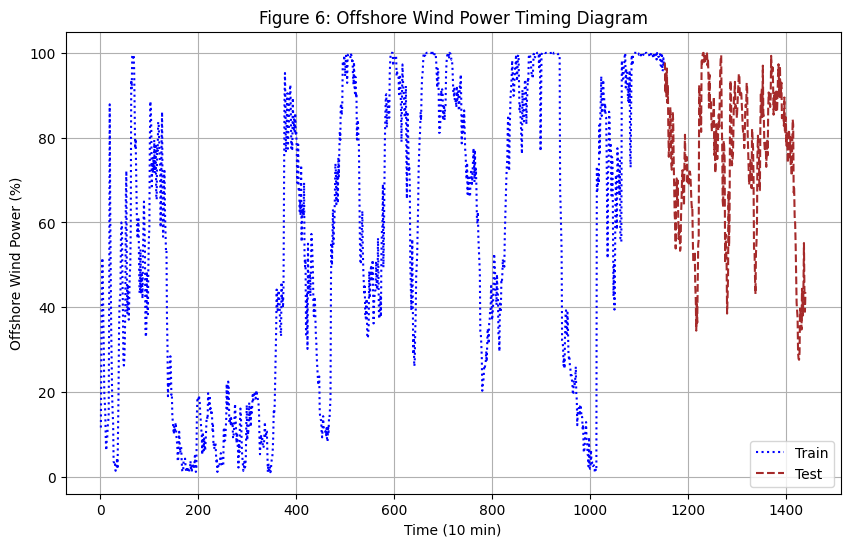

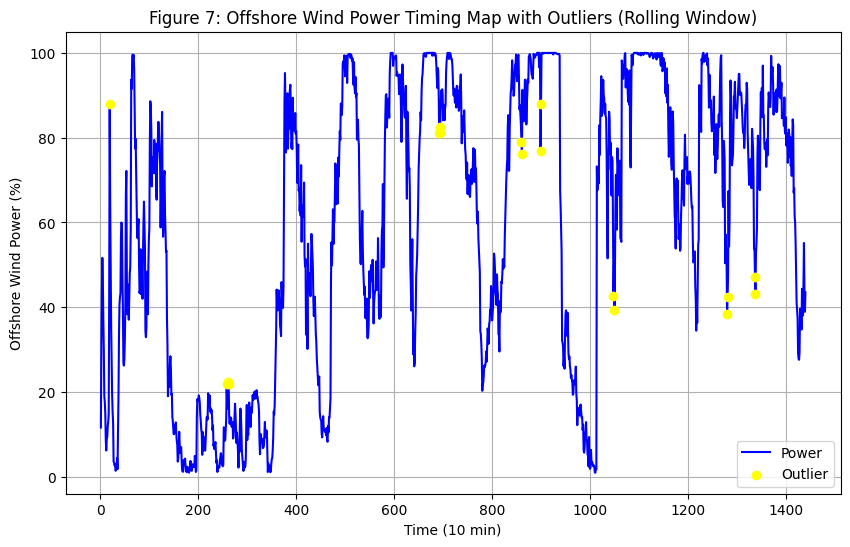

In [45]:
# Step 2: Select the first 1440 rows and extract relevant columns
data = data.iloc[:1440]  # Select only the first 1440 rows
time = np.arange(1, 1441)  # Generate time steps (1 to 1440)
# Clean column names
data.columns = data.columns.str.strip()  # Remove leading and trailing whitespaces
print("Cleaned Column Names:", data.columns)  # Check cleaned column names

# Access the 'y' column
power = data["y (% relative to rated power)"]  # Ensure this matches the cleaned column name


# Step 3: Plot Figure 6 - Offshore Wind Power Timing Diagram
train_size = int(0.8 * len(data))  # 80% train, 20% test split
train_power = power[:train_size]
test_power = power[train_size:]

plt.figure(figsize=(10, 6))
plt.plot(time[:train_size], train_power, label="Train", color="blue", linestyle="dotted")
plt.plot(time[train_size:], test_power, label="Test", color="brown", linestyle="dashed")
plt.xlabel("Time (10 min)")
plt.ylabel("Offshore Wind Power (%)")
plt.legend()
plt.title("Figure 6: Offshore Wind Power Timing Diagram")
plt.grid()
plt.show()
import numpy as np

window_size = 48
rolling_mean = []
rolling_std = []  # or rolling variance, depending on the exact interpretation

for i in range(len(power)):
    # Define the window boundaries (e.g., 48 points around i)
    # We'll do a simple centered window:
    start = max(0, i - window_size//2)
    end = min(len(power), i + window_size//2)
    # start = max(0, i)
    # end = min(len(power), i + window_size)

    window_data = power[start:end]

    # Compute mean & std (or variance)
    mu = window_data.mean()
    sigma = window_data.std()  # std is the sqrt of variance

    # Keep track if needed
    rolling_mean.append(mu)
    rolling_std.append(sigma)

# Now define outliers if data[i] is beyond mean ± 2*sigma in its window
outliers_mask = []
for i in range(len(power)):
    if power[i] < rolling_mean[i] - 2 * rolling_std[i] or power[i] > rolling_mean[i] + 2 * rolling_std[i]:
        outliers_mask.append(True)
    else:
        outliers_mask.append(False)

outliers_mask = np.array(outliers_mask)

# # Step 4: Outlier Detection Using Rolling Window (Paper's Method)

# Plot the power data with outliers highlighted (Figure 7)
plt.figure(figsize=(10, 6))
plt.plot(time, power, label="Power", color="blue")
plt.scatter(time[outliers_mask], power[outliers_mask], color="yellow", label="Outlier", zorder=5)
plt.xlabel("Time (10 min)")
plt.ylabel("Offshore Wind Power (%)")
plt.legend()
plt.title("Figure 7: Offshore Wind Power Timing Map with Outliers (Rolling Window)")
plt.grid()
plt.show()

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape

class Autoencoder:
    def __init__(self, window_size, latent_dim):
        """
        Initialize the Autoencoder class.
        Args:
            window_size (int): Number of time steps in each sequence (input dimension).
            latent_dim (int): Size of the latent space (latent dimension).
        """
        self.window_size = window_size
        self.latent_dim = latent_dim
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
    def build(self):
        """
        Build the Autoencoder, Encoder, and Decoder models.
        """
        # Encoder
        input_layer = Input(shape=(self.window_size, 1), name="Input_Layer")
        flattened = Flatten(name="Flatten_Layer")(input_layer)  # Flatten time-series input
        hidden1 = Dense(128, activation='relu', name="Hidden_Layer_1")(flattened)
        hidden2 = Dense(64, activation='relu', name="Hidden_Layer_2")(hidden1)
        latent_layer = Dense(self.latent_dim, activation='relu', name="Latent_Layer")(hidden2)
        # Decoder
        hidden3 = Dense(64, activation='relu', name="Decoder_Layer_1")(latent_layer)
        hidden4 = Dense(128, activation='relu', name="Decoder_Layer_2")(hidden3)
        output_flat = Dense(self.window_size, activation='linear', name="Output_Flat")(hidden4)
        output_layer = Reshape((self.window_size, 1), name="Output_Reshape")(output_flat)
        # Autoencoder Model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer, name="Autoencoder")
        # Encoder Model
        self.encoder = Model(inputs=input_layer, outputs=latent_layer, name="Encoder")

        # Decoder Model
        encoded_input = Input(shape=(self.latent_dim,), name="Encoded_Input")
        decoder_hidden1 = self.autoencoder.get_layer("Decoder_Layer_1")(encoded_input)
        decoder_hidden2 = self.autoencoder.get_layer("Decoder_Layer_2")(decoder_hidden1)
        decoder_flat = self.autoencoder.get_layer("Output_Flat")(decoder_hidden2)
        decoder_output = self.autoencoder.get_layer("Output_Reshape")(decoder_flat)
        self.decoder = Model(inputs=encoded_input, outputs=decoder_output, name="Decoder")

    def compile(self, optimizer='adam', loss='mse'):
        """
        Compile the Autoencoder model.

        Args:
            optimizer (str): Optimizer for training (default: 'adam').
            loss (str): Loss function to minimize (default: 'mse').
        """
        if not self.autoencoder:
            raise ValueError("The model must be built before compiling.")
        self.autoencoder.compile(optimizer=optimizer, loss=loss)

    def train(self, x_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.1):
        """
        Train the Autoencoder model.
        Args:
            x_train (np.array): Training input data (e.g., sequences of time steps).
            epochs (int): Number of epochs to train (default: 100).
            batch_size (int): Batch size for training (default: 16).
            shuffle (bool): Whether to shuffle the training data (default: True).
            validation_split (float): Fraction of data for validation (default: 0.1).

        Returns:
            History object: Contains training history.
        """
        if not self.autoencoder:
            raise ValueError("The model must be built and compiled before training.")
        return self.autoencoder.fit(
            x_train, x_train,  # Input and target are the same for autoencoders
            epochs=epochs,
            batch_size=batch_size,
            shuffle=shuffle,
            validation_split=validation_split
        )
    def summary(self):
        """
        Print the summary of the Autoencoder model.
        """
        if not self.autoencoder:
            raise ValueError("The model must be built before accessing the summary.")
        self.autoencoder.summary()


In [47]:
# Parameters
window_size = 144  # Time steps in each sequence
latent_dim = 16   # Size of the latent space

def create_sliding_windows(data, window_size):
    """
    Create sliding windows from the data.

    Args:
        data (np.array): Input data array (1D time-series).
        window_size (int): Number of time steps in each window.

    Returns:
        np.array: Array of sliding windows with shape (num_samples, window_size, 1).
    """
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows).reshape(-1, window_size, 1)

# Simulated input data (replace with your actual y column values)
sliding_windows = create_sliding_windows(power, window_size)

# Create and build the Autoencoder
autoencoder_model = Autoencoder(window_size, latent_dim)
autoencoder_model.build()

# Compile the Autoencoder
autoencoder_model.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
history = autoencoder_model.train(
    x_train=sliding_windows,
    epochs=100,
    batch_size=16,
    shuffle=True,
    validation_split=0.1
)

# Display the model summary
autoencoder_model.summary()

# Use the trained Autoencoder to "denoise" (reconstruct) the data
data_denoised = autoencoder_model.autoencoder.predict(sliding_windows)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2219.0161 - val_loss: 225.2601
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 376.5612 - val_loss: 215.7576
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 249.4622 - val_loss: 204.6001
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 221.2841 - val_loss: 185.7958
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166.7934 - val_loss: 161.6811
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130.2414 - val_loss: 145.5657
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115.1774 - val_loss: 132.6199
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.2392 - val_loss: 122.5053
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87.3201 - val_loss: 117.8985
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83.7786 - val_loss: 114.7809
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81.1644 - val_loss: 124.9333
Epoch 12/100
73/73 ━━

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)             │ (None, 144, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 144)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_1 (Dense)               │ (None, 128)                 │          18,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_2 (Dense)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Latent_Layer (Dense)                 │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Layer_1 (Dense)              │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Layer_2 (Dense)              │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Flat (Dense)                  │ (None, 144)                 │          18,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Reshape (Reshape)             │ (None, 144, 1)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,522 (654.39 KB)

 Trainable params: 55,840 (218.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 111,682 (436.26 KB)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


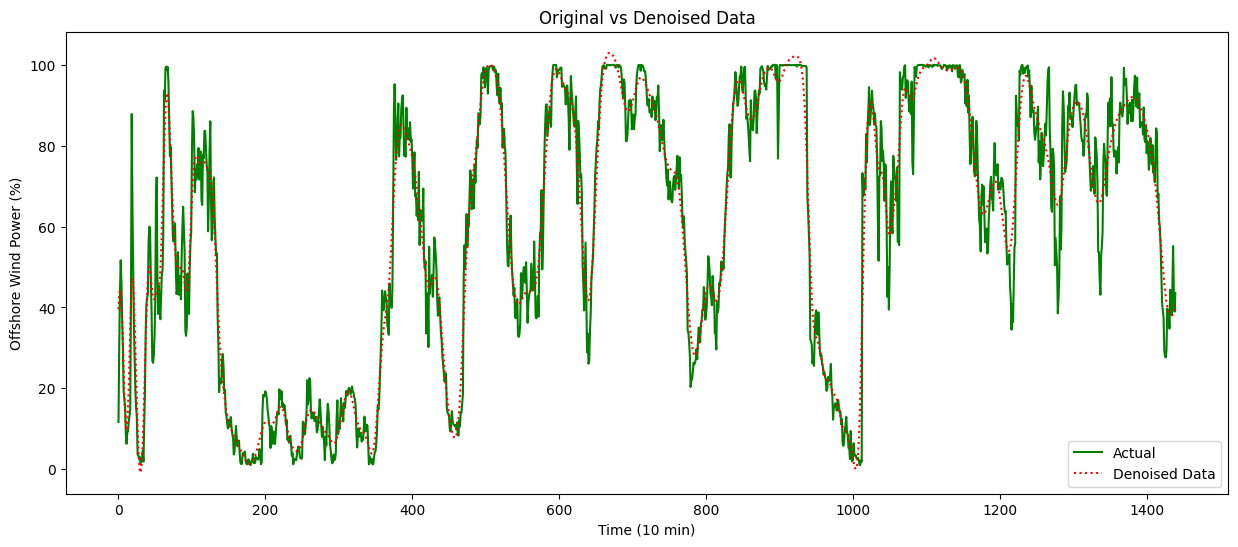

In [48]:
# Reconstruct the full denoised sequence from sliding windows
denoised_full = np.zeros((1440,))
count = np.zeros((1440,))  # Track the number of contributions for each time step

# Aggregate overlapping windows
for i in range(len(data_denoised)):
    denoised_full[i:i + window_size] += data_denoised[i].flatten()
    count[i:i + window_size] += 1

# Average overlapping regions
denoised_full /= count

# Plot original vs reconstructed data
plt.figure(figsize=(15, 6))
plt.plot(power, label="Actual", color="green")
plt.plot(denoised_full, label="Denoised Data", color="red", linestyle="dotted")
plt.xlabel("Time (10 min)")
plt.ylabel("Offshore Wind Power (%)")
plt.title("Original vs Denoised Data")
plt.legend()
plt.show()


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ------------------------------
# Step 1: Prepare Data
# ------------------------------

# PARAMETERS
window_size = 144  # e.g., 144 time steps for input
forecast_horizon = 1  # Predict 1 step ahead for single-step forecasting

# Replace the last column with the denoised data
data.iloc[:, -1] = denoised_full


X_full = data.iloc[:, 1:].values  # All columns except the first and last
y_full = data.iloc[:, -1].values   # Only the last column (target)



# ---------------------------------------------------------
# Step 2: Normalize Features and Target
# ---------------------------------------------------------
# Normalize all features together, including the target column
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)  # Scale columns together
print(data_scaled.shape)
# Split into train and test sets (80% train, 20% test)
train_ratio = 0.8
train_size = int(train_ratio * len(data_scaled))
data_train_scaled = data_scaled[:train_size]
data_test_scaled = data_scaled[train_size:]
print(data_train_scaled.shape)

print(f"Train size: {len(data_train_scaled)}, Test size: {len(data_test_scaled)}")

# ---------------------------------------------------------
# Step 3: Create Sliding Windows
# ---------------------------------------------------------
def create_sliding_windows(data, window_size, forecast_horizon):
    """
    Create input (X) and output (y) arrays using sliding windows.

    Args:
        data (np.array): Scaled data (features and target together).
        window_size (int): Number of time steps for input.
        forecast_horizon (int): How many steps ahead to predict.

    Returns:
        (X, y): Arrays for input (X) and target (y).
    """
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i : i + window_size, :-1])  # All features except target
        y.append(data[i + window_size : i + window_size + forecast_horizon, -1])  # Only target column
    return np.array(X), np.array(y)

# Create sliding windows for train and test sets
X_train, y_train = create_sliding_windows(data_train_scaled, window_size, forecast_horizon)
X_test, y_test = create_sliding_windows(data_test_scaled, window_size, forecast_horizon)

print("X_train shape:", X_train.shape)  # (samples, window_size, num_features)
print("y_train shape:", y_train.shape)  # (samples, forecast_horizon)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# ---------------------------------------------------------
# Step 4: Summary of Input and Output
# ---------------------------------------------------------
# X_train will now contain all input features (except `y`) for the sliding window
# y_train will contain the corresponding single-step target values (`y`)

print(f"Number of input features: {X_train.shape[-1]}")
print(f"Number of time steps in each input window: {X_train.shape[1]}")
print(f"Forecast horizon: {y_train.shape[-1]} (single-step prediction)")


(1440, 9)
(1152, 9)
Train size: 1152, Test size: 288
X_train shape: (1008, 144, 8)
y_train shape: (1008, 1)
X_test shape: (144, 144, 8)
y_test shape: (144, 1)
Number of input features: 8
Number of time steps in each input window: 144
Forecast horizon: 1 (single-step prediction)


In [50]:
# Step 5: Dataset Preparation

import torch
from torch.utils.data import Dataset, DataLoader
import math

class WindPowerDataset(Dataset):
    def __init__(self, X, y):
        """
        Initializes the dataset with input features and targets.

        Args:
            X (np.array): Input features of shape (num_samples, window_size).
            y (np.array): Targets of shape (num_samples,).
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch datasets
train_dataset = WindPowerDataset(X_train, y_train.flatten())
print(X_train.shape)
test_dataset = WindPowerDataset(X_test, y_test.flatten())

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


(1008, 144, 8)
Number of training samples: 1008
Number of testing samples: 144


In [51]:
import torch
import torch.nn as nn
import math

# Positional Encoding Class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Implements the sinusoidal positional encoding.

        Args:
            d_model (int): Embedding dimension.
            max_len (int): Maximum length of sequences.
        """
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(1)  # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Tensor of shape (seq_len, batch_size, d_model)

        Returns:
            torch.Tensor: Tensor with positional encoding added.
        """
        return x + self.pe[:x.size(0), :]

# Transformer Model with Positional Encoding
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=3, dim_feedforward=128, max_len=144):
        """
        Transformer model for single-step prediction with positional encoding.

        Args:
            input_dim (int): Number of input features per time step.
            d_model (int): Dimension of the embedding.
            nhead (int): Number of attention heads.
            num_layers (int): Number of transformer encoder layers.
            dim_feedforward (int): Dimension of the feedforward network.
            max_len (int): Maximum sequence length.
        """
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        Forward pass of the Transformer model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size, input_dim).

        Returns:
            torch.Tensor: Output predictions of shape (batch_size,).
        """
        x = self.embedding(x)  # Shape: (batch_size, window_size, d_model)
        x = x.permute(1, 0, 2)  # Shape: (window_size, batch_size, d_model)
        x = self.pos_encoder(x)  # Add positional encoding
        x = self.transformer_encoder(x)  # Shape: (window_size, batch_size, d_model)
        x = x[-1, :, :]  # Take the last time step: (batch_size, d_model)
        return self.fc_out(x).squeeze()  # Shape: (batch_size,)

# RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, fc_hidden_dim=64):
        """
        Enhanced RNN model with additional layers and neurons for single-step prediction.

        Args:
            input_dim (int): Number of input features per time step.
            hidden_dim (int): Number of hidden units in the RNN layers.
            num_layers (int): Number of RNN layers.
            fc_hidden_dim (int): Number of hidden units in the additional fully connected layer.
        """
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc_hidden = nn.Linear(hidden_dim, fc_hidden_dim)  # Additional fully connected hidden layer
        self.fc_out = nn.Linear(fc_hidden_dim, 1)  # Final output layer

    def forward(self, x):
        """
        Forward pass of the Enhanced RNN model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size, input_dim).

        Returns:
            torch.Tensor: Output predictions of shape (batch_size,).
        """
        rnn_out, _ = self.rnn(x)  # Shape: (batch_size, window_size, hidden_dim)
        rnn_out = rnn_out[:, -1, :]  # Take the last time step: (batch_size, hidden_dim)
        fc_hidden_out = torch.relu(self.fc_hidden(rnn_out))  # Apply activation to hidden layer
        return self.fc_out(fc_hidden_out).squeeze()  # Shape: (batch_size,)

# MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_sizes=[64, 32]):
        """
        MLP model for single-step prediction.

        Args:
            input_dim (int): Number of input features (flattened).
            hidden_sizes (list): List containing the sizes of hidden layers.
        """
        super(MLPModel, self).__init__()
        layers = []
        last_size = input_dim
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(last_size, hidden_size))
            layers.append(nn.ReLU())
            last_size = hidden_size
        layers.append(nn.Linear(last_size, 1))  # Output layer
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the MLP model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, window_size * input_dim).

        Returns:
            torch.Tensor: Output predictions of shape (batch_size,).
        """
        return self.network(x).squeeze()


In [57]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class CustomHuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        """
        Initializes the CustomHuberLoss module.

        Args:
            delta (float): Threshold for switching between quadratic and linear loss. Default is 1.0.
        """
        super().__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        """
        Computes the Huber loss.

        Args:
            y_pred (torch.Tensor): Predicted values. Shape: (batch_size,)
            y_true (torch.Tensor): True values. Shape: (batch_size,)

        Returns:
            torch.Tensor: Average Huber loss.
        """
        error = y_pred - y_true
        abs_error = torch.abs(error)
        loss = torch.where(
            abs_error <= self.delta,
            0.5 * error**2,
            self.delta * (abs_error - 0.5 * self.delta)
        )
        return loss.mean()



# Step 7: Define Loss Functions

# Define loss functions with CustomHuberLoss
loss_functions = {
    'MSE': nn.MSELoss(),
    'Huber': CustomHuberLoss(delta=1.0)
}
# Training parameters
num_epochs = 80
learning_rate = 0.001

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define evaluation metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate RMSE, MAE, and MAPE metrics.

    Args:
        y_true (np.array): Actual target values.
        y_pred (np.array): Predicted target values.

    Returns:
        tuple: RMSE, MAE, MAPE
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # To avoid division by zero, add a small epsilon where y_true is zero
    epsilon = 1e-10
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    return rmse, mae, mape

# Initialize results storage
results = []

# Define model classes mapping
model_classes = {
    'Transformer': TransformerModel,
    'RNN': RNNModel,
    'MLP': MLPModel
}

# Define the number of input features per time step
num_features = X_train.shape[-1]  # Automatically set to the number of features
print(num_features)

# Iterate through each model and loss function combination
for model_name, model_class in model_classes.items():
    for loss_name, criterion in loss_functions.items():
        print(f"\nTraining {model_name} with {loss_name} loss")

        # Instantiate a new model for each combination to ensure fresh weights
        if model_name == 'Transformer':
            model = TransformerModel(
                input_dim=8,  # Use multi-feature input
                d_model=64,
                nhead=4,  # As per paper's specification
                num_layers=3,
                dim_feedforward=128,
                max_len=144
            ).to(device)
        elif model_name == 'RNN':
            model = RNNModel(
                input_dim=8,  # Use multi-feature input
                hidden_dim=64,
                num_layers=2
            ).to(device)
        elif model_name == 'MLP':
            model = MLPModel(
                input_dim=window_size * 8,  # Flattened input
                hidden_sizes=[64, 32]
            ).to(device)
        else:
            raise ValueError(f"Unknown model name: {model_name}")

        # Define optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        for epoch in range(1, num_epochs + 1):
            model.train()
            epoch_loss = 0
            for batch_X, batch_y in train_loader:
                if model_name == 'MLP':
                    batch_X = batch_X.view(batch_X.size(0), -1)  # Flatten input for MLP
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)



                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * batch_X.size(0)

            epoch_loss /= len(train_loader.dataset)

            # Print loss every 10 epochs and the first epoch
            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Evaluation
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                if model_name == 'MLP':
                    batch_X = batch_X.view(batch_X.size(0), -1)  # Flatten input for MLP
                outputs = model(batch_X)


        # Convert tensors to NumPy arrays
        outputs_np = outputs.cpu().numpy()  # Shape: (batch_size, 1)
        batch_y_np = batch_y.cpu().numpy()  # Shape: (batch_size, 1)

        # Create a placeholder with zeros for other features
        num_features = data.shape[1]  # Total number of features used for scaling
        outputs_padded = np.zeros((outputs_np.shape[0], num_features))
        batch_y_padded = np.zeros((batch_y_np.shape[0], num_features))

        # Replace only the last column (wind power) with actual predictions/targets
        outputs_padded[:, -1] = outputs_np.flatten()  # Fill last column with predictions
        batch_y_padded[:, -1] = batch_y_np.flatten()  # Fill last column with true values

        # Perform inverse transformation
        outputs_inv = scaler.inverse_transform(outputs_padded)[:, -1]  # Extract last column
        batch_y_inv = scaler.inverse_transform(batch_y_padded)[:, -1]  # Extract last column

        # Extend the lists with the inverse-transformed values
        all_preds.extend(outputs_inv)
        all_targets.extend(batch_y_inv)


        # Calculate metrics on original scale
        rmse, mae, mape = calculate_metrics(np.array(all_targets), np.array(all_preds))

        print(f"Evaluation Metrics for {model_name} with {loss_name} loss:")
        print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

        # Store results
        results.append({
            'Model': model_name,
            'Loss': loss_name,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape
        })
        print('Model', model_name,
            'Loss', loss_name,
            'RMSE', rmse,
            'MAE', mae,
            'MAPE', mape)


8

Training Transformer with MSE loss


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/80], Loss: 0.1466
Epoch [10/80], Loss: 0.0104
Epoch [20/80], Loss: 0.0037
Epoch [30/80], Loss: 0.0032
Epoch [40/80], Loss: 0.0024
Epoch [50/80], Loss: 0.0026
Epoch [60/80], Loss: 0.0022
Epoch [70/80], Loss: 0.0013
Epoch [80/80], Loss: 0.0012
Evaluation Metrics for Transformer with MSE loss:
RMSE: 7.1588, MAE: 5.5385, MAPE: 13.38%
Model Transformer Loss MSE RMSE 7.158771966148869 MAE 5.538475347485198 MAPE 13.38214482304401

Training Transformer with Huber loss


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/80], Loss: 0.1370
Epoch [10/80], Loss: 0.0036
Epoch [20/80], Loss: 0.0025
Epoch [30/80], Loss: 0.0015
Epoch [40/80], Loss: 0.0011
Epoch [50/80], Loss: 0.0009
Epoch [60/80], Loss: 0.0008
Epoch [70/80], Loss: 0.0006
Epoch [80/80], Loss: 0.0005
Evaluation Metrics for Transformer with Huber loss:
RMSE: 9.8435, MAE: 8.8134, MAPE: 21.55%
Model Transformer Loss Huber RMSE 9.843538685458585 MAE 8.813410066938285 MAPE 21.54500545509707

Training RNN with MSE loss
Epoch [1/80], Loss: 0.1672
Epoch [10/80], Loss: 0.0048
Epoch [20/80], Loss: 0.0036
Epoch [30/80], Loss: 0.0029
Epoch [40/80], Loss: 0.0023
Epoch [50/80], Loss: 0.0022
Epoch [60/80], Loss: 0.0019
Epoch [70/80], Loss: 0.0026
Epoch [80/80], Loss: 0.0019
Evaluation Metrics for RNN with MSE loss:
RMSE: 3.5387, MAE: 2.8800, MAPE: 6.98%
Model RNN Loss MSE RMSE 3.538713132070404 MAE 2.8800173946588483 MAPE 6.984972416590549

Training RNN with Huber loss
Epoch [1/80], Loss: 0.0943
Epoch [10/80], Loss: 0.0023
Epoch [20/80], Loss: 0.0020

In [62]:
# Step 9: Results Presentation

import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Pivot the DataFrame to have Models as rows and Loss functions as columns for each metric
pivot_rmse = results_df.pivot(index='Model', columns='Loss', values='RMSE')
pivot_mae = results_df.pivot(index='Model', columns='Loss', values='MAE')
pivot_mape = results_df.pivot(index='Model', columns='Loss', values='MAPE')

# Combine the pivot tables
final_table = pd.concat([pivot_rmse, pivot_mae, pivot_mape], axis=1)
final_table.columns = ['RMSE (Huber)', 'RMSE (MSE)', 'MAE (Huber)', 'MAE (MSE)', 'MAPE (Huber)', 'MAPE (MSE)']

# Reorder columns for better readability
final_table = final_table[['RMSE (Huber)', 'RMSE (MSE)', 'MAE (Huber)', 'MAE (MSE)', 'MAPE (Huber)', 'MAPE (MSE)']]

# Display the table
print("\nEvaluation Metrics Table:")
print(final_table.round(4))



Evaluation Metrics Table:
             RMSE (Huber)  RMSE (MSE)  MAE (Huber)  MAE (MSE)  MAPE (Huber)  \
Model                                                                         
MLP                3.6604     10.2629       2.6196     9.6248        6.4974   
RNN                5.5852      3.5387       4.8347     2.8800       11.8551   
Transformer        9.8435      7.1588       8.8134     5.5385       21.5450   

             MAPE (MSE)  
Model                    
MLP             24.0203  
RNN              6.9850  
Transformer     13.3821  


In [63]:
import pandas as pd
# 1) Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(results)
# 2) Create pivot tables for each metric
pivot_rmse = df.pivot(index='Model', columns='Loss', values='RMSE')
pivot_mae = df.pivot(index='Model', columns='Loss', values='MAE')
pivot_mape = df.pivot(index='Model', columns='Loss', values='MAPE')

# 3) Combine the pivot tables (side by side)
final_table = pd.concat([pivot_rmse, pivot_mae, pivot_mape], axis=1)

# 4) Rename the columns for clarity
final_table.columns = [
    'RMSE (Huber)', 'RMSE (MSE)',
    'MAE (Huber)',  'MAE (MSE)',
    'MAPE (Huber)', 'MAPE (MSE)'
]

# 5) Reorder the columns for better readability
final_table = final_table[[
    'RMSE (Huber)', 'RMSE (MSE)',
    'MAE (Huber)',  'MAE (MSE)',
    'MAPE (Huber)', 'MAPE (MSE)'
]]

print("**Evaluation Metrics Summary (Wide Format)**")
display(final_table.round(4))

################################################################################
#                RESHAPING TO [Index, Model, MSE, Huber]
################################################################################

# 6) Reset index to make 'Model' a column
final_table_reset = final_table.reset_index()
# 7) Melt the DataFrame
long_df = final_table_reset.melt(
    id_vars='Model',
    var_name='MetricLoss',
    value_name='Value'
)
# 8) Extract MetricName and Loss type
long_df['Index'] = long_df['MetricLoss'].str.split(' ').str[0]  # Get RMSE/MAE/MAPE
loss_type = long_df['MetricLoss'].str.extract(r'\((.*?)\)')  # Get MSE/Huber

# 9) Create the final summary table
final_summary = (long_df
    .assign(MSE=long_df['Value'].where(loss_type[0] == 'MSE'),
            Huber=long_df['Value'].where(loss_type[0] == 'Huber'))
    .groupby(['Index', 'Model'])
    .agg({
        'MSE': 'first',
        'Huber': 'first'
    })
    .reset_index()
)

# 10) Ensure correct column order
final_summary = final_summary[['Index', 'Model', 'MSE', 'Huber']]

# 11) Sort metrics in desired order and only show Index for first occurrence
metric_order = ['MAE', 'MAPE', 'RMSE']
final_summary['Index'] = pd.Categorical(final_summary['Index'], categories=metric_order, ordered=True)
final_summary = final_summary.sort_values(['Index', 'Model']).reset_index(drop=True)

# 12) Replace repeated Index values with empty string
final_summary['Index'] = final_summary.groupby('Index')['Index'].transform(
    lambda x: [x.iloc[0]] + [''] * (len(x) - 1)
)

print("\n**Evaluation Metrics Summary (Long Format) [Index, Model, MSE, Huber]**")
display(final_summary.round(4))

**Evaluation Metrics Summary (Wide Format)**


,RMSE (Huber),RMSE (MSE),MAE (Huber),MAE (MSE),MAPE (Huber),MAPE (MSE)
Model,,,,,,
MLP,3.6604,10.2629,2.6196,9.6248,6.4974,24.0203
RNN,5.5852,3.5387,4.8347,2.8800,11.8551,6.9850
Transformer,9.8435,7.1588,8.8134,5.5385,21.5450,13.3821



**Evaluation Metrics Summary (Long Format) [Index, Model, MSE, Huber]**


<ipython-input-63-11d5443fb325>:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_summary['Index'] = final_summary.groupby('Index')['Index'].transform(


,Index,Model,MSE,Huber
0,MAE,MLP,9.6248,2.6196
1,,RNN,2.8800,4.8347
2,,Transformer,5.5385,8.8134
3,MAPE,MLP,24.0203,6.4974
4,,RNN,6.9850,11.8551
5,,Transformer,13.3821,21.5450
6,RMSE,MLP,10.2629,3.6604
7,,RNN,3.5387,5.5852
8,,Transformer,7.1588,9.8435


In [21]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error

class MultiStepTransformer(nn.Module):
    def __init__(self, input_dim, output_steps, d_model=64, nhead=4, num_layers=3, dim_feedforward=128, max_len=144):
        """
        Multi-step Transformer model for predicting multiple time steps ahead.

        Args:
            input_dim (int): Number of input features per time step
            output_steps (int): Number of time steps to predict
            d_model (int): Dimension of the model
            nhead (int): Number of attention heads
            num_layers (int): Number of transformer layers
            dim_feedforward (int): Dimension of feedforward network
            max_len (int): Maximum sequence length
        """
        super(MultiStepTransformer, self).__init__()
        self.d_model = d_model
        self.output_steps = output_steps

        # Input embedding
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                  dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Output layer modified for multi-step prediction
        self.fc_out = nn.Linear(d_model, output_steps)
    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_dim)

        Returns:
            torch.Tensor: Predictions of shape (batch_size, output_steps)
        """
        # No need to unsqueeze if input_dim > 1
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[-1, :, :]  # Take the last sequence element
        return self.fc_out(x)  # (batch_size, output_steps)

class MultiStepWindPowerDataset(Dataset):
    def __init__(self, X, y_steps):
        self.X = torch.tensor(X, dtype=torch.float32)  # Now 3D: (num_samples, seq_len, input_dim)
        self.y_steps = {k: torch.tensor(v, dtype=torch.float32) for k, v in y_steps.items()}

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], {k: v[idx] for k, v in self.y_steps.items()}

# Time step analysis
sample_interval = 10  # minutes per time step
forecast_steps = [4, 8, 16]
print("\nTime step analysis:")
for step in forecast_steps:
    minutes = step * sample_interval
    print(f"t+{step} corresponds to {minutes} minutes ahead prediction")


Time step analysis:
t+4 corresponds to 40 minutes ahead prediction
t+8 corresponds to 80 minutes ahead prediction
t+16 corresponds to 160 minutes ahead prediction


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

def train_multi_step_transformer(model, train_loader, test_loader, scaler, device,
                               num_epochs=50, learning_rate=0.001, print_interval=10):
    """
    Training function for multi-step transformer model.

    Args:
        model: MultiStepTransformer model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        scaler: Scaler object for inverse transformation
        device: torch device
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        print_interval: Interval for printing training progress

    Returns:
        dict: Training history and final evaluation metrics
    """
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Storage for training history
    history = {
        'train_loss': [],
        'eval_metrics': []
    }

    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0
        batch_count = 0

        # Training step
        for batch_X, batch_y_dict in train_loader:
            batch_X = batch_X.to(device)
            # Stack all target horizons into a single tensor
            batch_y = torch.stack([y.to(device) for y in batch_y_dict.values()], dim=1)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

        avg_epoch_loss = epoch_loss / batch_count
        history['train_loss'].append(avg_epoch_loss)

        # Evaluation and printing at intervals
        if epoch % print_interval == 0 or epoch == 1:
            print(f"\nEpoch [{epoch}/{num_epochs}]")
            print(f"Training Loss: {avg_epoch_loss:.4f}")

            # Evaluate on test set
            eval_metrics = evaluate_multi_step(model, test_loader, scaler, device)
            history['eval_metrics'].append({
                'epoch': epoch,
                **eval_metrics
            })

            # Print metrics for each prediction horizon
            for horizon, metrics in eval_metrics.items():
                print(f"\nHorizon {horizon}:")
                print(f"RMSE: {metrics['rmse']:.4f}")
                print(f"MAE: {metrics['mae']:.4f}")
                print(f"MAPE: {metrics['mape']:.2f}%")

    return history

def evaluate_multi_step(model, test_loader, scaler, device):
    """
    Evaluate the multi-step model with proper inverse normalization.

    Args:
        model: MultiStepTransformer model
        test_loader: DataLoader for test data
        scaler: Scaler object for inverse transformation
        device: torch device

    Returns:
        dict: Evaluation metrics for each prediction horizon
    """
    model.eval()
    predictions = {}
    targets = {}

    with torch.no_grad():
        for batch_X, batch_y_dict in test_loader:
            batch_X = batch_X.to(device)
            # Get model predictions
            outputs = model(batch_X).cpu().numpy()

            # Process each prediction horizon
            for i, (horizon, target) in enumerate(batch_y_dict.items()):
                if horizon not in predictions:
                    predictions[horizon] = []
                    targets[horizon] = []

                # Important: Ensure proper reshaping for inverse transform
                # The scaler expects 2D array with shape (n_samples, n_features)
                pred = outputs[:, i].reshape(-1, 1)
                true = target.numpy().reshape(-1, 1)

                # Debug prints to verify values before inverse transform
                print(f"\nBefore inverse transform for horizon {horizon}:")
                print(f"Predictions range: {pred.min():.4f} to {pred.max():.4f}")
                print(f"Targets range: {true.min():.4f} to {true.max():.4f}")

                # Inverse transform both predictions and targets
                pred_inv = scaler.inverse_transform(pred).flatten()
                true_inv = scaler.inverse_transform(true).flatten()

                # Debug prints after inverse transform
                print(f"\nAfter inverse transform for horizon {horizon}:")
                print(f"Predictions range: {pred_inv.min():.4f} to {pred_inv.max():.4f}")
                print(f"Targets range: {true_inv.min():.4f} to {true_inv.max():.4f}")

                predictions[horizon].extend(pred_inv)
                targets[horizon].extend(true_inv)

    # Calculate metrics on the inverse-transformed values
    metrics = {}
    for horizon in predictions.keys():
        pred_array = np.array(predictions[horizon])
        true_array = np.array(targets[horizon])

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(true_array, pred_array))
        mae = mean_absolute_error(true_array, pred_array)

        # Calculate MAPE with handling for zero values
        epsilon = 1e-10
        mape = np.mean(np.abs((true_array - pred_array) / (np.abs(true_array) + epsilon))) * 100

        metrics[horizon] = {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            # Add value ranges for verification
            'pred_range': [pred_array.min(), pred_array.max()],
            'true_range': [true_array.min(), true_array.max()]
        }

        # Print detailed metrics for verification
        print(f"\nDetailed metrics for horizon {horizon}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Prediction range: {pred_array.min():.4f} to {pred_array.max():.4f}")
        print(f"True value range: {true_array.min():.4f} to {true_array.max():.4f}")

    return metrics



In [25]:
# Assuming `data` is your DataFrame
features = X_full
target = y_full

# Normalize features and target separately
from sklearn.preprocessing import MinMaxScaler
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.reshape(-1, 1)).flatten()


In [26]:
def create_multistep_windows(features, target, window_size, forecast_steps):
    """
    Create windows for multi-step prediction.

    Args:
        features (np.array): Input features (2D array: num_samples x num_features)
        target (np.array): Target variable (1D array)
        window_size (int): Size of input window
        forecast_steps (list): List of steps ahead to predict

    Returns:
        tuple: X array (features) and dictionary of y arrays for each forecast step
    """
    X, y_dict = [], {step: [] for step in forecast_steps}

    for i in range(len(target) - window_size - max(forecast_steps) + 1):
        X.append(features[i:i + window_size, :])  # Include all features in the window
        for step in forecast_steps:
            y_dict[step].append(target[i + window_size + step - 1])  # Corresponding target values

    return np.array(X), {k: np.array(v) for k, v in y_dict.items()}


In [27]:
# Split data into train and test
train_size = int(0.8 * len(features_scaled))
features_train, features_test = features_scaled[:train_size], features_scaled[train_size:]
target_train, target_test = target_scaled[:train_size], target_scaled[train_size:]

# Define parameters
window_size = 144
forecast_steps = [4, 8, 16]

# Create windows
X_train, y_train_dict = create_multistep_windows(features_train, target_train, window_size, forecast_steps)
X_test, y_test_dict = create_multistep_windows(features_test, target_test, window_size, forecast_steps)

print(f"X_train shape: {X_train.shape}")  # Should be (num_samples, seq_len, num_features)
print(f"y_train_dict keys: {y_train_dict.keys()}")
print(f"y_train_dict[4] shape: {y_train_dict[4].shape}")


X_train shape: (993, 144, 8)
y_train_dict keys: dict_keys([4, 8, 16])
y_train_dict[4] shape: (993,)


In [33]:
class MultiStepWindPowerDataset(Dataset):
    def __init__(self, X, y_steps):
        self.X = torch.tensor(X, dtype=torch.float32)  # Shape: (num_samples, seq_len, num_features)
        self.y_steps = {k: torch.tensor(v, dtype=torch.float32) for k, v in y_steps.items()}

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], {k: v[idx] for k, v in self.y_steps.items()}

# Create datasets
train_dataset = MultiStepWindPowerDataset(X_train, y_train_dict)
test_dataset = MultiStepWindPowerDataset(X_test, y_test_dict)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [37]:
model_multi = MultiStepTransformer(
    input_dim=X_train.shape[-1],  # Automatically set to the number of features
    output_steps=len(forecast_steps),
    d_model=64,
    nhead=4,
    num_layers=3
).to(device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [38]:
history = train_multi_step_transformer(
    model_multi,
    train_loader,
    test_loader,
    target_scaler,  # Pass the scaler for inverse transformation
    device,
    num_epochs=150,
    learning_rate=0.001
)



Epoch [1/150]
Training Loss: 0.1196

Before inverse transform for horizon 4:
Predictions range: 0.5752 to 0.7024
Targets range: 0.6556 to 0.8828

After inverse transform for horizon 4:
Predictions range: 59.4664 to 72.7043
Targets range: 67.8323 to 91.4916

Before inverse transform for horizon 8:
Predictions range: 0.6535 to 0.7231
Targets range: 0.6081 to 0.8669

After inverse transform for horizon 8:
Predictions range: 67.6173 to 74.8677
Targets range: 62.8918 to 89.8348

Before inverse transform for horizon 16:
Predictions range: 0.5164 to 0.5880
Targets range: 0.5989 to 0.8291

After inverse transform for horizon 16:
Predictions range: 53.3415 to 60.7904
Targets range: 61.9333 to 85.9018

Before inverse transform for horizon 4:
Predictions range: 0.5063 to 0.6563
Targets range: 0.5989 to 0.8339

After inverse transform for horizon 4:
Predictions range: 52.2817 to 67.9119
Targets range: 61.9333 to 86.4015

Before inverse transform for horizon 8:
Predictions range: 0.6341 to 0.7088


In [39]:
# Evaluation after training
model_multi.eval()
predictions = {}
targets = {}

# Collect predictions and targets for all forecast horizons
with torch.no_grad():
    for batch_X, batch_y_dict in test_loader:
        batch_X = batch_X.to(device)

        # Get model predictions
        outputs = model_multi(batch_X).cpu().numpy()

        for i, (horizon, target) in enumerate(batch_y_dict.items()):
            if horizon not in predictions:
                predictions[horizon] = []
                targets[horizon] = []

            # Reshape predictions and targets for inverse transform
            pred = outputs[:, i].reshape(-1, 1)  # (batch_size, 1)
            true = target.numpy().reshape(-1, 1)  # (batch_size, 1)

            # Create placeholders with zeros for all features
            num_features = data.shape[1]  # Total number of features (9 in your case)
            pred_padded = np.zeros((pred.shape[0], num_features))  # Shape: (batch_size, num_features)
            true_padded = np.zeros((true.shape[0], num_features))  # Shape: (batch_size, num_features)

            # Fill the last column (wind power) with predictions and targets
            pred_padded[:, -1] = pred.flatten()
            true_padded[:, -1] = true.flatten()

            # Apply inverse transform
            pred_inv = scaler.inverse_transform(pred_padded)[:, -1]  # Extract the last column
            true_inv = scaler.inverse_transform(true_padded)[:, -1]  # Extract the last column

            # Append the inverse-transformed values
            predictions[horizon].extend(pred_inv)
            targets[horizon].extend(true_inv)

            # Debugging
            print(f"\nBefore inverse transform for horizon {horizon}:")
            print(f"Predictions range: {pred.min():.4f} to {pred.max():.4f}")
            print(f"Targets range: {true.min():.4f} to {true.max():.4f}")
            print(f"\nAfter inverse transform for horizon {horizon}:")
            print(f"Predictions range: {pred_inv.min():.4f} to {pred_inv.max():.4f}")
            print(f"Targets range: {true_inv.min():.4f} to {true_inv.max():.4f}")

# Calculate and print metrics
results = []
for horizon in predictions.keys():
    pred_array = np.array(predictions[horizon])
    true_array = np.array(targets[horizon])

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(true_array, pred_array))
    mae = mean_absolute_error(true_array, pred_array)
    epsilon = 1e-10  # To handle division by zero
    mape = np.mean(np.abs((true_array - pred_array) / (np.abs(true_array) + epsilon))) * 100

    # Store metrics for each horizon
    results.append({
        'Horizon': f't+{horizon}',
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })

    # Print metrics
    print(f"\nMetrics for t+{horizon}:")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

# Convert results to DataFrame for a clean table view
results_df = pd.DataFrame(results)

print("\n**Evaluation Metrics Summary**")
display(results_df.round(4))



Before inverse transform for horizon 4:
Predictions range: 0.8414 to 0.9298
Targets range: 0.6556 to 0.8828

After inverse transform for horizon 4:
Predictions range: 87.1794 to 96.3852
Targets range: 67.8323 to 91.4916

Before inverse transform for horizon 8:
Predictions range: 0.8580 to 0.9359
Targets range: 0.6081 to 0.8669

After inverse transform for horizon 8:
Predictions range: 88.9158 to 97.0246
Targets range: 62.8918 to 89.8348

Before inverse transform for horizon 16:
Predictions range: 0.7809 to 0.9172
Targets range: 0.5989 to 0.8291

After inverse transform for horizon 16:
Predictions range: 80.8880 to 95.0752
Targets range: 61.9333 to 85.9019

Before inverse transform for horizon 4:
Predictions range: 0.7786 to 0.9477
Targets range: 0.5989 to 0.8339

After inverse transform for horizon 4:
Predictions range: 80.6423 to 98.2496
Targets range: 61.9333 to 86.4015

Before inverse transform for horizon 8:
Predictions range: 0.8371 to 0.8921
Targets range: 0.5989 to 0.8339

Afte

,Horizon,RMSE,MAE,MAPE
0,t+4,10.4042,8.7134,11.4797
1,t+8,14.2471,11.7196,15.7167
2,t+16,22.7925,19.5234,27.6430
